In [84]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages')
import os.path
sys.path.append('util')

import set_compiler
set_compiler.install()

import pyximport
pyximport.install()
import json
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('OVI')
import lda_ovi

Compiling with /usr/local/bin/clang-omp


# Loading data

### Loading Yelp features

In [2]:
# Loading the features extracted from YELP
restaurants_lasvegas = pd.read_pickle('temp/restaurants_lasvegas')

In [3]:
# Listing the categories selected
categories = restaurants_lasvegas.columns[-73:].values
restaurants_lasvegas[categories].sum()

Chicken Wings                 85
American (New)               280
Tapas/Small Plates            16
Taiwanese                     12
Bagels                        12
Coffee & Tea                  43
Buffets                       88
Gluten-Free                   20
Arts & Entertainment          45
Breakfast & Brunch           156
Indian                        26
Food Stands                   33
Sandwiches                   354
Latin American                29
Fast Food                    553
Korean                        65
Sushi Bars                   142
Barbeque                      93
Food                         257
Filipino                      37
Hawaiian                      57
Dim Sum                       15
Beer, Wine & Spirits          19
Vietnamese                    56
Southern                      25
French                        31
Pubs                          62
Tapas Bars                    19
Szechuan                      12
Diners                        49
          

In [4]:
from sklearn.cross_validation import train_test_split

# Cleaning the data from the labels
data_exp = restaurants_lasvegas.reset_index()
data_exp = data_exp.drop(['business_id', 'state', 'city'], axis=1)
data_exp = data_exp.drop(['categories', 'categories_top', 'num_cat'], axis=1)

# Split train/test set
itrain, itest = train_test_split(xrange(data_exp.shape[0]), train_size=0.7)
mask=np.ones(data_exp.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

train_set = data_exp[mask]
test_set = data_exp[~mask]

### Loading reviews features

In [6]:
# Getting the mapping: bid2index
with open('temp/bidtoindex.json', 'r') as f:
    bidtoindex = json.load(f)
bidtoindex_list = [t[0] for t in sorted(bidtoindex.items(), key=lambda x: x[1])]

In [81]:
# OVI features
gamma_ovi = np.load('temp/reviews_features/ovi_54_gamma.npy')
gamma_ovi_df = pd.DataFrame(data=gamma_ovi, index=bidtoindex_list)

# OVI topics (in case we would like to explorate the meaning of a topic)
topics_ovi = np.load('temp/reviews_features/ovi_54_topics.npy')
# vocabulary
lv_vocab10 = np.load('temp/Lasvegas_data/lv_vocab10.npy')

In [8]:
# NMF features
gamma_nmf = np.load('temp/reviews_features/nmf_54_gamma.npy')
gamma_nmf_df = pd.DataFrame(data=gamma_nmf, index=bidtoindex_list)

In [95]:
# Package Gibbs sampler
gamma_gs = np.load('temp/reviews_features/lda_gs_54_gamma.npy')
gamma_gs_df = pd.DataFrame(data=gamma_gs, index=bidtoindex_list)

# GS topics
topics_gs = np.load('temp/reviews_features/lda_gs_54_topics.npy')

In [10]:
# Building the work df for ovi
ovi_df = restaurants_lasvegas.merge(gamma_ovi_df, how='left', right_index=True, left_index=True)

# Dictionaary of the output for each labels
Y_ovi_train = {}
Y_ovi_test = {}
for category in categories:
    Y_ovi_train[category] = ovi_df[mask][category].values
    Y_ovi_test[category] = ovi_df[~mask][category].values

# Cleaning the data from the labels
ovi_df = ovi_df.reset_index()
ovi_df = ovi_df.drop(['business_id', 'state', 'city', 'categories', 'categories_top', 'num_cat'], axis=1)

    
# Features
ovi_df_train = ovi_df[mask].drop(categories, axis=1)
ovi_df_test = ovi_df[~mask].drop(categories, axis=1)

print 'Train set length is', len(ovi_df_train)
print 'Train set length is', len(ovi_df_test)

Train set length is 2620
Train set length is 1123


In [11]:
# Building the work df for NMF
nmf_df = restaurants_lasvegas.merge(gamma_nmf_df, how='left', right_index=True, left_index=True)

# Dictionaary of the output for each labels
Y_nmf_train = {}
Y_nmf_test = {}
for category in categories:
    Y_nmf_train[category] = nmf_df[mask][category].values
    Y_nmf_test[category] = nmf_df[~mask][category].values

# Cleaning the data from the labels
nmf_df = nmf_df.reset_index()
nmf_df = nmf_df.drop(['business_id', 'state', 'city', 'categories', 'categories_top', 'num_cat'], axis=1)

    
# Features
nmf_df_train = nmf_df[mask].drop(categories, axis=1).values.astype(float)
nmf_df_test = nmf_df[~mask].drop(categories, axis=1).values.astype(float)

print 'Train set length is', len(nmf_df_train)
print 'Train set length is', len(nmf_df_test)

Train set length is 2620
Train set length is 1123


In [12]:
# Building the work df for Gibbs Sampling
gs_df = restaurants_lasvegas.merge(gamma_gs_df, how='left', right_index=True, left_index=True)

# Dictionaary of the output for each labels
Y_gs_train = {}
Y_gs_test = {}
for category in categories:
    Y_gs_train[category] = gs_df[mask][category].values
    Y_gs_test[category] = gs_df[~mask][category].values

# Cleaning the data from the labels
gs_df = gs_df.reset_index()
gs_df = gs_df.drop(['business_id', 'state', 'city', 'categories', 'categories_top', 'num_cat'], axis=1)

    
# Features
gs_df_train = gs_df[mask].drop(categories, axis=1).values.astype(float)
gs_df_test = gs_df[~mask].drop(categories, axis=1).values.astype(float)

print 'Train set length is', len(gs_df_train)
print 'Train set length is', len(gs_df_test)

Train set length is 2620
Train set length is 1123


In [13]:
# Structure of the features for Las vegas (in the df train and test, ovi_df still contains the categories)
checkin_indices = range(5,173)
indicator_indices = [2] + range(173, 198)
numerical_indices = [0, 1, 3, 4]
reviews_indices = range(198, ovi_df_train.shape[1])
len(ovi_df.columns[indicator_indices])

26

In [14]:
print'Number of features directly provided by Yelp', len(checkin_indices) + len(indicator_indices) + len(numerical_indices)

Number of features directly provided by Yelp 198


# Exploratory Analysis

We plot here for each category the scatter plot of the topic ditribution for each entry. We hope to see strongly activated topics which corresponds to specific categories.

In [138]:
#Filter the top categories
categories_serie = restaurants_lasvegas[categories].sum()
categories_serie.sort(ascending=False)
top_10 = categories_serie[:10].index.values
categories_serie

Fast Food                    553
Mexican                      476
American (Traditional)       403
Pizza                        365
Sandwiches                   354
Nightlife                    345
Bars                         322
Burgers                      296
Chinese                      286
American (New)               280
Food                         257
Italian                      232
Japanese                     201
Breakfast & Brunch           156
Steakhouses                  149
Sushi Bars                   142
Seafood                      132
Thai                         103
Cafes                         97
Sports Bars                   96
Barbeque                      93
Asian Fusion                  91
Buffets                       88
Chicken Wings                 85
Delis                         85
Mediterranean                 68
Korean                        65
Pubs                          62
Hot Dogs                      57
Hawaiian                      57
          

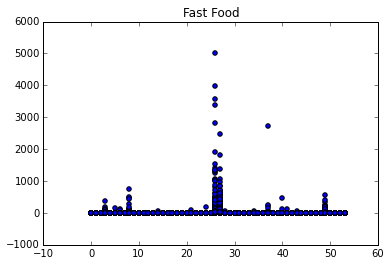

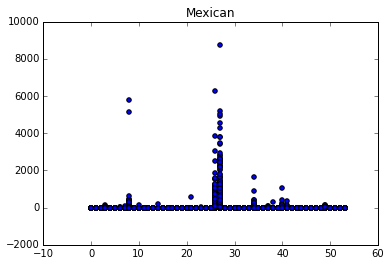

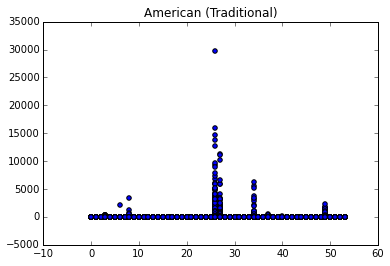

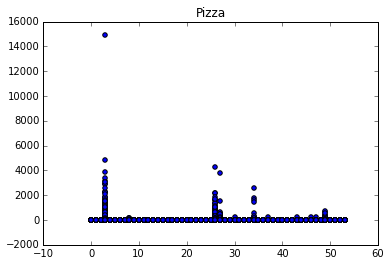

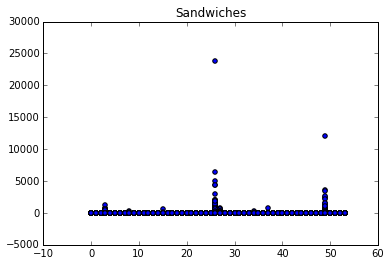

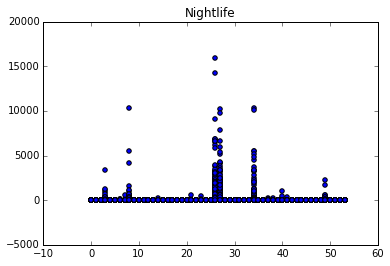

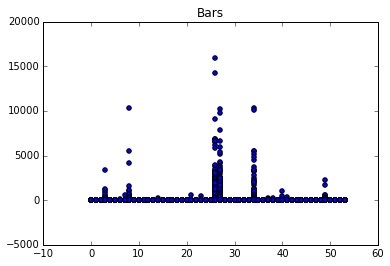

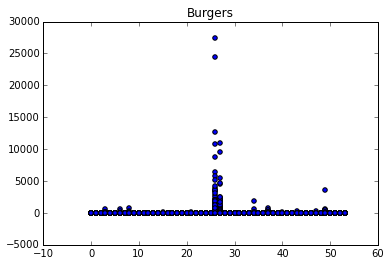

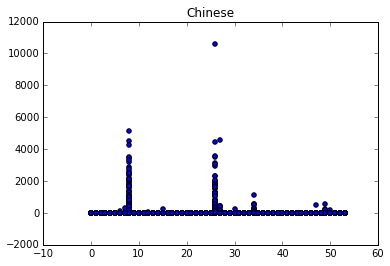

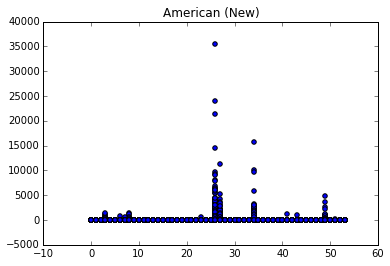

In [66]:
# OVI features
for category in top_10:
    for i, row in ovi_df[ovi_df[category]][ovi_df.columns[-54:]].iterrows():
        plt.scatter(range(len(row)), row.values)
        plt.title(category)
    plt.show()

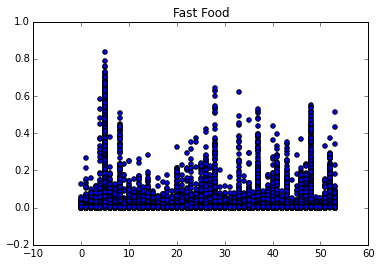

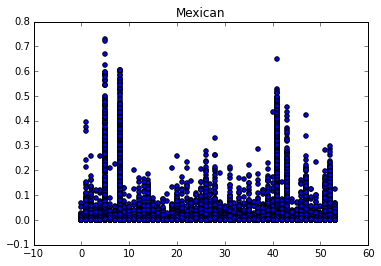

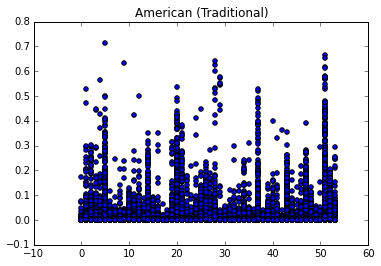

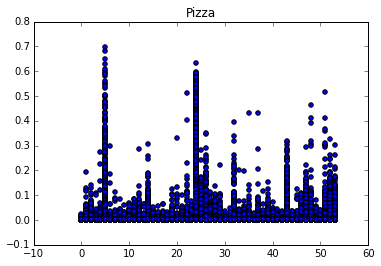

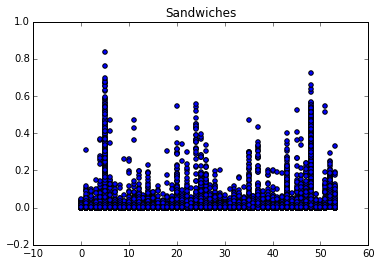

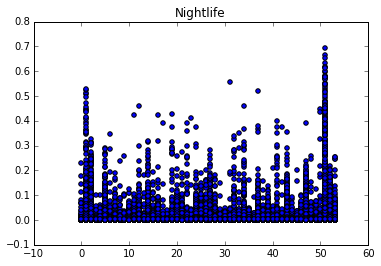

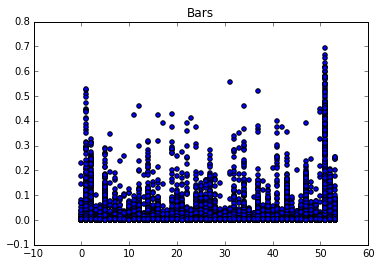

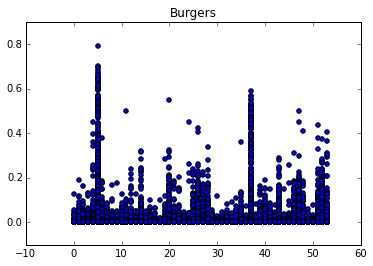

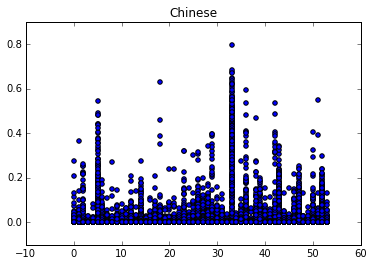

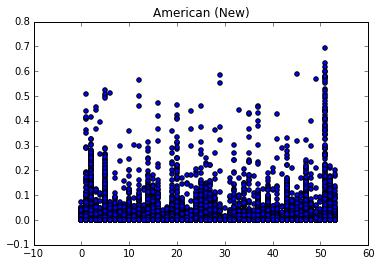

In [117]:
# GS features
for category in top_10:
    for i, row in gs_df[gs_df[category]][gs_df.columns[-54:]].iterrows():
        plt.scatter(range(len(row)), row.values)
        plt.title(category)
    plt.show()

It seems that 2 features are stronglyu activated with no regards to the category (number 7 and 8). We could try to remove them from the features used in the model.

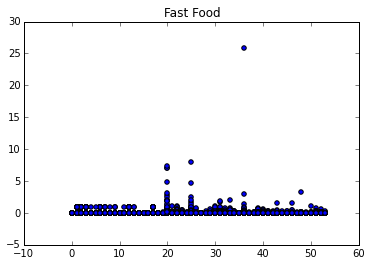

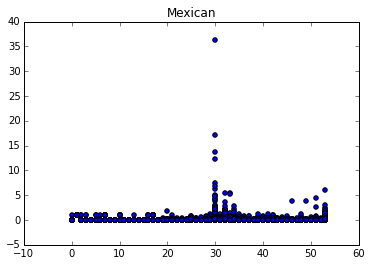

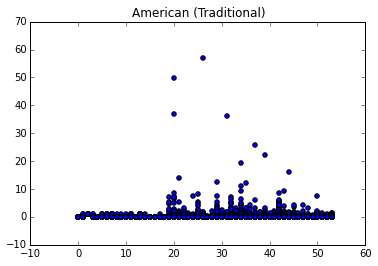

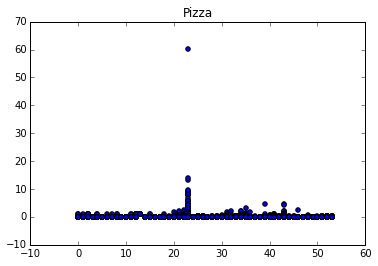

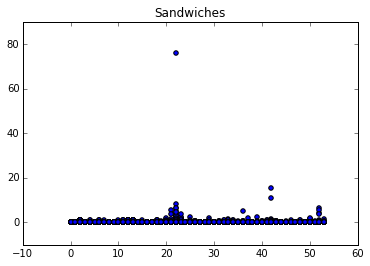

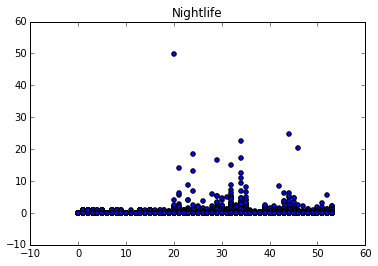

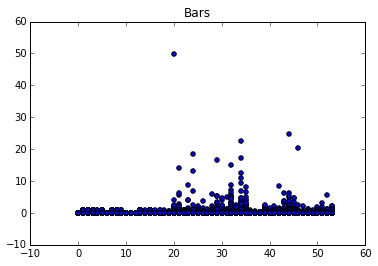

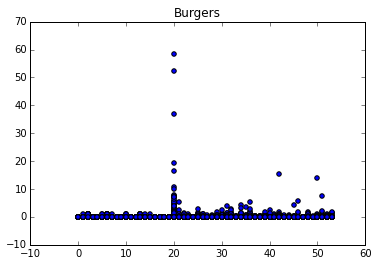

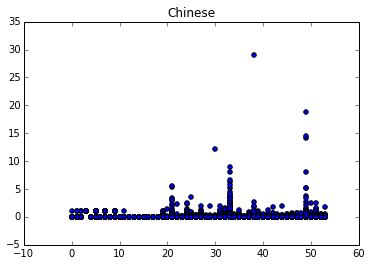

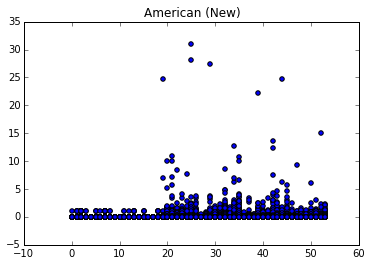

In [67]:
# NMF features
for category in top_10:
    for i, row in nmf_df[nmf_df[category]][nmf_df.columns[-54:]].iterrows():
        plt.scatter(range(len(row)), row.values)
        plt.title(category)
    plt.show()

# Classification

#### Summary
The Best model is random forest with GS LDA.

### Exploratory tricks to improve the Classifications

We have to deal with a multi-label problem. We chose to treat it with one-vs-all classifier.

In [29]:
# The dataset is higly skewed. We build a balanced one to train the model
ovi_df_train_balanced = {}
Y_df_train_balanced = {}
for category in top_10:
    n_pos = sum(Y_ovi_train[category])
    ineg = np.random.choice(ovi_df_train[Y_ovi_train[category] == 0].index, n_pos, replace=False)
    alli=np.concatenate((ovi_df_train[Y_ovi_train[category] == 1].index, ineg))
    ovi_df_train_balanced[category] = ovi_df_train.loc[alli]
    Y_df_train_balanced[category] = (ovi_df[mask][category].loc[alli]).values

Test of unbalanced training set not convincing

In [15]:
# To normalize the features (based in the train set)
def normalize_features(X_train, X_test):
    mean_X_train = np.mean(X_train, 0)
    std_X_train = np.std(X_train, 0)
    std_X_train[std_X_train == 0] = 1
    X_train_normalized = (X_train - mean_X_train) / std_X_train
    X_test_normalized = (X_test - mean_X_train) / std_X_train
    return X_train_normalized, X_test_normalized

In [16]:
# Normalizing some features
ovi_df_train_normalized = ovi_df_train.copy()
ovi_df_test_normalized = ovi_df_test.copy()
ovi_df_train_normalized[ovi_df_train_normalized.columns[reviews_indices]], ovi_df_test_normalized[ovi_df_test_normalized.columns[reviews_indices]] = normalize_features(ovi_df_train[ovi_df_train.columns[reviews_indices]].values.astype(float), ovi_df_test[ovi_df_test.columns[reviews_indices]].values.astype(float))

We tested to normalize both numerical and reviews features against the l2 regularized logistic regression, the accuracy decreased.

Test not convincing with normalization of the reviews features or the numerical features.

In [60]:
# Removing the noisy features of ovi lda
ovi_noisy_features = [7, 8]
ovi_df_train_wo = ovi_df_train.drop(ovi_noisy_features, axis=1)
ovi_df_test_wo = ovi_df_test.drop(ovi_noisy_features, axis=1)

Test not convincing, these features seem to be discrimant for at least 1 class.
One notable fact is that the gibbs sampler version provides a topics assignement distributed more evenly than the OVI, where only a few topics seem to be activated

In [132]:
# PCA to reduce the dimension of the YELP properties 
# apply on the checkin
from  sklearn.decomposition import PCA
# We keep 95% of the variance

pca = PCA(n_components=0.95)
%time pca.fit(gs_df.drop(categories, axis=1).values[:, checkin_indices])
checkin_pca = pca.transform(gs_df.drop(categories, axis=1).values[:, checkin_indices])
gs_df_pca = np.concatenate((gs_df.drop(categories, axis=1).values[:, indicator_indices + numerical_indices + reviews_indices], checkin_pca), axis=1)
print('PCA reduced the dimension from {} to {}'.format(len(checkin_indices), pca.n_components_))
# Retrieving column name
gs_df_pca_columns = list(gs_df.drop(categories, axis=1).columns[indicator_indices + numerical_indices + reviews_indices]) + ['pca_{}'.format(i) for i in xrange(pca.n_components_)]

nmf_df_pca = np.concatenate((nmf_df.drop(categories, axis=1).values[:, indicator_indices + numerical_indices + reviews_indices], checkin_pca), axis=1)

ovi_df_pca = np.concatenate((ovi_df.drop(categories, axis=1).values[:, indicator_indices + numerical_indices + reviews_indices], checkin_pca), axis=1)
# Retrieving column name
ovi_df_pca_columns = list(ovi_df.drop(categories, axis=1).columns[indicator_indices + numerical_indices + reviews_indices]) + ['pca_{}'.format(i) for i in xrange(pca.n_components_)] 

CPU times: user 163 ms, sys: 34 ms, total: 197 ms
Wall time: 168 ms
PCA reduced the dimension from 168 to 19


In [108]:
gs_df_pca_train = gs_df_pca[mask]
gs_df_pca_test = gs_df_pca[~mask]

nmf_df_pca_train = nmf_df_pca[mask]
nmf_df_pca_test = nmf_df_pca[~mask]

ovi_df_pca_train = ovi_df_pca[mask]
ovi_df_pca_test = ovi_df_pca[~mask]

In [109]:
# Checking the shape
print gs_df_pca_train.shape
print gs_df_pca_test.shape

print nmf_df_pca_train.shape
print nmf_df_pca_test.shape

print ovi_df_pca_train.shape
print ovi_df_pca_test.shape

(2620, 103)
(1123, 103)
(2620, 103)
(1123, 103)
(2620, 103)
(1123, 103)


### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [46]:
import scipy.optimize as opt

# Logistic Regression

def sigmoid(x):
    return 1./(1 + np.exp(-x))


def y_hat(X, w, thresh=0.5):
    y_hat = sigmoid(np.dot(X, w))
    y_hat[y_hat >= thresh] = 1
    y_hat[y_hat != 1] = 0
    return y_hat


def negative_log_likelihood(w, X, y, sigma_2):
    '''
    Compute the the negative log likelihood of the model in the logistic regression
    '''
    mu = sigmoid(np.dot(X, w))
    NLL = -(np.dot(np.transpose(y), np.log(mu)) + np.dot(np.transpose(1 - y),
            np.log(1 - mu)))
    return NLL + 1./sigma_2 * np.dot(np.transpose(w), w)


def negative_log_likelihood_grad(w, X, y, sigma_2):
    '''
    Compute the gradient of the negative log likelihood wrt w.
    '''
    mu = sigmoid(np.dot(X, w))
    g = np.dot(np.transpose(X), mu - y)
    return g + 2./sigma_2 * w
    
def get_mse(X, y, w):
    N = X.shape[0]
    err = y - y_hat(X, w)
    return np.dot(err.T, err) / (1. * N)


def logistic_regression_fit(X, y, sigma_2, maxiter=1000):
    '''
    Return the weights of the l2 regularized logistic regression
    fitted to (X, y)
    '''
    # Initialization
    w_0 = np.zeros(X.shape[1])
    res = opt.minimize(negative_log_likelihood, w_0, args=(X, y, sigma_2,),
                       jac=negative_log_likelihood_grad, method='L-BFGS-B',
                       options={'maxiter': maxiter})
    return res.x


def logistic_regression_cv(X, y, sigma_2_range, n_fold=10, maxiter=1000):
    '''
    Cross validate a logistic regression to find the best sigma_2 value
    in the range sigma_2_range.
    Returns the weights and the best sigma_2 as a tuple
    '''
    # Shuffle the data
    data_shuffle = np.random.permutation(np.concatenate((X, np.reshape(y, (len(y), 1))), 1))
    y_ = data_shuffle[:, -1]
    X_ = data_shuffle[:, :-1]

    N = X_.shape[0]
    s = N / n_fold
    
    # (sigma_2, cv_error) dictionnary
    err_cv_dict = {}
    
    for sigma_2 in sigma_2_range:
        err_cv = 0
        for i in xrange(n_fold):
            X_train_fold = np.concatenate((X_[:i * s, :], X_[(i + 1) * s:, :]), 0)
            y_train_fold = np.concatenate((y_[:i * s], y_[(i + 1) * s:]), 0)

            w_cv = logistic_regression_fit(X_train_fold, y_train_fold, sigma_2)
            err = y_[i * s:(i + 1) * s] - y_hat(X_[i * s:(i + 1) * s, :], w_cv)
            err_cv += np.dot(err.T, err)
        err_cv_dict[sigma_2] = err_cv / N
    
    # Finding the best sigma
    min_err = np.min(err_cv_dict.values())
    best_sigma_2 = np.max([sig for sig in err_cv_dict if err_cv_dict[sig] == min_err])

    # Fitting the logistic regression for the new sigma
    w = logistic_regression_fit(X, y, best_sigma_2)
    return w, best_sigma_2

In [35]:
all_false = 0
log_reg_acc_ovi = 0
log_reg_acc_ovi_pca = 0
log_reg_acc_gs = 0
log_reg_acc_gs_pca = 0
log_reg_acc_nmf = 0
log_reg_acc_nmf_pca = 0

for category in top_10:
    # OVI features
    log_reg = LogisticRegression(penalty='l2')
    %time log_reg.fit(ovi_df_train, Y_ovi_train[category])
    log_reg_a = log_reg.score(ovi_df_test, Y_ovi_test[category])
    # OVI features after PCA
    log_reg_ovi_pca = LogisticRegression(penalty='l2')
    log_reg_ovi_pca.fit(ovi_df_pca_train, Y_ovi_train[category])
    log_reg_ovi_pca_a = log_reg_ovi_pca.score(ovi_df_pca_test, Y_ovi_test[category])
    # GS features
    log_reg_gs = LogisticRegression(penalty='l2')
    log_reg_gs.fit(gs_df_train, Y_gs_train[category])
    log_reg_gs_a = log_reg_gs.score(gs_df_test, Y_gs_test[category])
    # GS features after PCA
    log_reg_gs_pca = LogisticRegression(penalty='l2')
    log_reg_gs_pca.fit(gs_df_pca_train, Y_gs_train[category])
    log_reg_gs_pca_a = log_reg_gs_pca.score(gs_df_pca_test, Y_gs_test[category])
    # NMF features
    log_reg_nmf = LogisticRegression(penalty='l2')
    log_reg_nmf.fit(nmf_df_train, Y_nmf_train[category])
    log_reg_nmf_a = log_reg_nmf.score(nmf_df_test, Y_ovi_test[category])
    # NMF features after PCA
    log_reg_nmf_pca = LogisticRegression(penalty='l2')
    log_reg_nmf_pca.fit(nmf_df_pca_train, Y_nmf_train[category])
    log_reg_nmf_pca_a = log_reg_nmf_pca.score(nmf_df_pca_test, Y_nmf_test[category])
    
    # Global accuracy of the multi-label classification task
    all_false += accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    log_reg_acc_ovi += log_reg_a
    log_reg_acc_ovi_pca += log_reg_ovi_pca_a
    log_reg_acc_gs += log_reg_gs_a
    log_reg_acc_gs_pca += log_reg_gs_pca_a
    log_reg_acc_nmf += log_reg_nmf_a
    log_reg_acc_nmf_pca += log_reg_nmf_pca_a
    
    # Result case by case
    # print '----------------Category:   {} ------------------'.format(category)
    # print 'All True accuracy: %s' % accuracy_score(Y_ovi_test[category], np.ones(ovi_df_test.shape[0]))
    # print 'All False accuracy: %s' % accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    # print 'Classifier on OVI accuracy: %s' % log_reg_a
    # print 'Classifier on GS accuracy: %s' % log_reg_gs_a
    # print 'Classifier on GS after PCA accuracy: %s' % log_reg_gs_pca_a
    # print 'Classifier on NMF accuracy: %s' % log_reg_nmf_a
    # print 'Number of predicted True %s' % log_reg.predict(ovi_df_test).sum()
    # print 'Number of predicted True %s wo noise' % log_reg_wo.predict(ovi_df_test_wo).sum()
    # print 'Number of predicted True %s NMF' % log_reg_nmf.predict(nmf_df_test).sum()

# Global results
print('Total accuracy for each l2 log reg classifier')
print 'All False: ', all_false
print 'OVI: ', log_reg_acc_ovi
print 'OVI with PCA: ', log_reg_acc_ovi_pca
print 'GS: ', log_reg_acc_gs
print 'GS with PCA: ', log_reg_acc_gs_pca
print 'NMF: ', log_reg_acc_nmf
print 'NMF with PCA: ', log_reg_acc_nmf_pca
# Latek format
print log_reg_acc_ovi, ' & ', log_reg_acc_gs, ' & ', log_reg_acc_nmf
print log_reg_acc_ovi_pca, ' & ', log_reg_acc_gs_pca, ' & ', log_reg_acc_nmf_pca


CPU times: user 1.73 s, sys: 118 ms, total: 1.85 s
Wall time: 2.12 s
CPU times: user 1.52 s, sys: 23.4 ms, total: 1.54 s
Wall time: 1.58 s
CPU times: user 1.36 s, sys: 26.4 ms, total: 1.39 s
Wall time: 1.81 s
CPU times: user 1.4 s, sys: 29.7 ms, total: 1.43 s
Wall time: 1.55 s
CPU times: user 1.35 s, sys: 18 ms, total: 1.37 s
Wall time: 1.4 s
CPU times: user 1.4 s, sys: 17.6 ms, total: 1.42 s
Wall time: 1.43 s
CPU times: user 1.41 s, sys: 27.3 ms, total: 1.43 s
Wall time: 1.57 s
CPU times: user 989 ms, sys: 13 ms, total: 1 s
Wall time: 1.01 s
CPU times: user 924 ms, sys: 8.76 ms, total: 933 ms
Wall time: 937 ms
CPU times: user 1.07 s, sys: 9.36 ms, total: 1.08 s
Wall time: 1.08 s
Total accuracy for each l2 log reg classifier
All False:  9.03383793411
OVI:  9.13980409617
OVI with PCA:  9.30988423865
GS:  9.18699910953
GS with PCA:  9.3143365984
NMF:  9.18699910953
NMF with PCA:  9.30632235085
9.13980409617  &  9.18699910953  &  9.18699910953
9.30988423865  &  9.3143365984  &  9.30632235

In [23]:
all_false = 0
lasso_acc_ovi = 0
lasso_acc_ovi_pca = 0
lasso_acc_gs = 0
lasso_acc_gs_pca = 0
lasso_acc_nmf = 0
lasso_acc_nmf_pca = 0

for category in top_10:
    # OVI features
    lasso = LogisticRegression(penalty='l1')
    %time lasso.fit(ovi_df_train, Y_ovi_train[category])
    lasso_a = lasso.score(ovi_df_test, Y_ovi_test[category])
    # OVI features after PCA
    lasso_ovi_pca = LogisticRegression(penalty='l1')
    lasso_ovi_pca.fit(ovi_df_pca_train, Y_ovi_train[category])
    lasso_ovi_pca_a = lasso_ovi_pca.score(ovi_df_pca_test, Y_ovi_test[category])
    # GS features
    lasso_gs = LogisticRegression(penalty='l1')
    lasso_gs.fit(gs_df_train, Y_gs_train[category])
    lasso_gs_a = lasso_gs.score(gs_df_test, Y_gs_test[category])
    # GS features after PCA
    lasso_gs_pca = LogisticRegression(penalty='l1')
    lasso_gs_pca.fit(gs_df_pca_train, Y_gs_train[category])
    lasso_gs_pca_a = lasso_gs_pca.score(gs_df_pca_test, Y_gs_test[category])
    # NMF features
    lasso_nmf = LogisticRegression(penalty='l1')
    lasso_nmf.fit(nmf_df_train, Y_nmf_train[category])
    lasso_nmf_a = lasso_nmf.score(nmf_df_test, Y_ovi_test[category])
    # NMF features after PCA
    lasso_nmf_pca = LogisticRegression(penalty='l1')
    lasso_nmf_pca.fit(nmf_df_pca_train, Y_nmf_train[category])
    lasso_nmf_pca_a = lasso_nmf_pca.score(nmf_df_pca_test, Y_nmf_test[category])
    
    # Global accuracy of the multi-label classification task
    all_false += accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    lasso_acc_ovi += lasso_a
    lasso_acc_ovi_pca += lasso_ovi_pca_a
    lasso_acc_gs += lasso_gs_a
    lasso_acc_gs_pca += lasso_gs_pca_a
    lasso_acc_nmf += lasso_nmf_a
    lasso_acc_nmf_pca += lasso_nmf_pca_a
    
    # Result case by case
    # print '----------------Category:   {} ------------------'.format(category)
    # print 'All True accuracy: %s' % accuracy_score(Y_ovi_test[category], np.ones(ovi_df_test.shape[0]))
    # print 'All False accuracy: %s' % accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    # print 'Classifier on OVI accuracy: %s' % lasso_a
    # print 'Classifier on GS accuracy: %s' % lasso_gs_a
    # print 'Classifier on GS after PCA accuracy: %s' % lasso_gs_pca_a
    # print 'Classifier on NMF accuracy: %s' % lasso_nmf_a
    # print 'Number of predicted True %s' % lasso.predict(ovi_df_test).sum()
    # print 'Number of predicted True %s wo noise' % lasso_wo.predict(ovi_df_test_wo).sum()
    # print 'Number of predicted True %s NMF' % lasso_nmf.predict(nmf_df_test).sum()

# Global results
print('Total accuracy for each lasso classifier')
print 'All False: ', all_false
print 'OVI: ', lasso_acc_ovi
print 'OVI with PCA: ', lasso_acc_ovi_pca
print 'GS: ', lasso_acc_gs
print 'GS with PCA: ', lasso_acc_gs_pca
print 'NMF: ', lasso_acc_nmf
print 'NMF with PCA: ', lasso_acc_nmf_pca
# Latek format
print lasso_acc_ovi, ' & ', lasso_acc_gs, ' & ', lasso_acc_nmf
print lasso_acc_ovi_pca, ' & ', lasso_acc_gs_pca, ' & ', lasso_acc_nmf_pca


CPU times: user 1.74 s, sys: 36.8 ms, total: 1.77 s
Wall time: 1.9 s
CPU times: user 918 ms, sys: 12 ms, total: 930 ms
Wall time: 940 ms
CPU times: user 1.14 s, sys: 13.9 ms, total: 1.15 s
Wall time: 1.21 s
CPU times: user 432 ms, sys: 9.5 ms, total: 441 ms
Wall time: 459 ms
CPU times: user 436 ms, sys: 5.9 ms, total: 442 ms
Wall time: 444 ms
CPU times: user 885 ms, sys: 13.3 ms, total: 898 ms
Wall time: 912 ms
CPU times: user 784 ms, sys: 9.09 ms, total: 793 ms
Wall time: 801 ms
CPU times: user 649 ms, sys: 8.49 ms, total: 657 ms
Wall time: 663 ms
CPU times: user 854 ms, sys: 14.9 ms, total: 869 ms
Wall time: 904 ms
CPU times: user 1.08 s, sys: 10.6 ms, total: 1.09 s
Wall time: 1.11 s
Total accuracy for each lasso classifier
All False:  9.03383793411
OVI:  9.11843276937
OVI with PCA:  9.38913624221
GS:  9.37666963491
GS with PCA:  9.48797862867
NMF:  9.24131789849
NMF with PCA:  9.34372217275
9.11843276937  &  9.37666963491  &  9.24131789849
9.38913624221  &  9.48797862867  &  9.34372

### SVM

In [31]:
# Scikit SVM test:
from sklearn import svm

In [34]:
all_false = 0
clf_acc_ovi = 0
clf_acc_ovi_pca = 0
clf_acc_gs = 0
clf_acc_gs_pca = 0
clf_acc_nmf = 0
clf_acc_nmf_pca = 0
clf_acc_ovi_b_pca = 0

for category in top_10:
    # OVI features
    clf = svm.SVC(kernel='rbf')
    %time clf.fit(ovi_df_train, Y_ovi_train[category])
    clf_a = clf.score(ovi_df_test, Y_ovi_test[category])
    # OVI features after PCA
    clf_ovi_pca = svm.SVC(kernel='rbf')
    clf_ovi_pca.fit(ovi_df_pca_train, Y_ovi_train[category])
    clf_ovi_pca_a = clf_ovi_pca.score(ovi_df_pca_test, Y_ovi_test[category])
    # OVI features after PCA on balanced
    clf_ovi_pca_b = svm.SVC(kernel='rbf')
    clf_ovi_pca_b.fit(ovi_df_train_balanced[category], Y_df_train_balanced[category])
    clf_ovi_pca_b_a = clf_ovi_pca_b.score(ovi_df_test, Y_ovi_test[category])
    # GS features
    clf_gs = svm.SVC(kernel='rbf')
    clf_gs.fit(gs_df_train, Y_gs_train[category])
    clf_gs_a = clf_gs.score(gs_df_test, Y_gs_test[category])
    # GS features after PCA
    clf_gs_pca = svm.SVC(kernel='rbf')
    clf_gs_pca.fit(gs_df_pca_train, Y_gs_train[category])
    clf_gs_pca_a = clf_gs_pca.score(gs_df_pca_test, Y_gs_test[category])
    # NMF features
    clf_nmf = svm.SVC(kernel='rbf')
    clf_nmf.fit(nmf_df_train, Y_nmf_train[category])
    clf_nmf_a = clf_nmf.score(nmf_df_test, Y_ovi_test[category])
    # NMF features after PCA
    clf_nmf_pca = svm.SVC(kernel='rbf')
    clf_nmf_pca.fit(nmf_df_pca_train, Y_nmf_train[category])
    clf_nmf_pca_a = clf_nmf_pca.score(nmf_df_pca_test, Y_nmf_test[category])
        
    
    # Global accuracy of the multi-label classification task
    all_false += accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    clf_acc_ovi += clf_a
    clf_acc_ovi_pca += clf_ovi_pca_a
    clf_acc_gs += clf_gs_a
    clf_acc_gs_pca += clf_gs_pca_a
    clf_acc_nmf += clf_nmf_a
    clf_acc_nmf_pca += clf_nmf_pca_a
    clf_acc_ovi_b_pca += clf_ovi_pca_b_a
    
    # Result case by case
    # print '----------------Category:   {} ------------------'.format(category)
    # print 'All True accuracy: %s' % accuracy_score(Y_ovi_test[category], np.ones(ovi_df_test.shape[0]))
    # print 'All False accuracy: %s' % accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    # print 'Classifier on OVI accuracy: %s' % clf_a
    # print 'Classifier on GS accuracy: %s' % clf_gs_a
    # print 'Classifier on GS after PCA accuracy: %s' % clf_gs_pca_a
    # print 'Classifier on NMF accuracy: %s' % clf_nmf_a
    # print 'Number of predicted True %s' % clf.predict(ovi_df_test).sum()
    # print 'Number of predicted True %s wo noise' % clf_wo.predict(ovi_df_test_wo).sum()
    # print 'Number of predicted True %s NMF' % clf_nmf.predict(nmf_df_test).sum()

# Global results
print('Total accuracy for each SVM classifier')
print 'All False: ', all_false
print 'OVI: ', clf_acc_ovi
print 'OVI with PCA: ', clf_acc_ovi_pca
print 'OVI with PCA on unbalanced: ', clf_acc_ovi_b_pca
print 'GS: ', clf_acc_gs
print 'GS with PCA: ', clf_acc_gs_pca
print 'NMF: ', clf_acc_nmf
print 'NMF with PCA: ', clf_acc_nmf_pca
# Latek format
print clf_acc_ovi, ' & ', clf_acc_gs, ' & ', clf_acc_nmf
print clf_acc_ovi_pca, ' & ', clf_acc_gs_pca, ' & ', clf_acc_nmf_pca


CPU times: user 2.2 s, sys: 29.4 ms, total: 2.23 s
Wall time: 2.29 s
CPU times: user 2.32 s, sys: 34.2 ms, total: 2.35 s
Wall time: 2.46 s
CPU times: user 2.87 s, sys: 58.5 ms, total: 2.93 s
Wall time: 3.38 s
CPU times: user 2.15 s, sys: 15.8 ms, total: 2.16 s
Wall time: 2.18 s
CPU times: user 2.34 s, sys: 24.8 ms, total: 2.36 s
Wall time: 2.46 s
CPU times: user 2.1 s, sys: 10.9 ms, total: 2.11 s
Wall time: 2.12 s
CPU times: user 2.12 s, sys: 13.5 ms, total: 2.13 s
Wall time: 2.15 s
CPU times: user 2.19 s, sys: 16.2 ms, total: 2.2 s
Wall time: 2.23 s
CPU times: user 2.09 s, sys: 9.83 ms, total: 2.1 s
Wall time: 2.1 s
CPU times: user 2.48 s, sys: 32.6 ms, total: 2.52 s
Wall time: 2.7 s
Total accuracy for each SVM classifier
All False:  9.03383793411
OVI:  9.10062333037
OVI with PCA:  9.09617097061
OVI with PCA on unbalanced:  6.43187889581
GS:  9.07301869991
GS with PCA:  9.08548530721
NMF:  9.06767586821
NMF with PCA:  9.08548530721
9.10062333037  &  9.07301869991  &  9.06767586821
9.0

### Random Forest

In [25]:
# Scikit Random Forest
from sklearn.ensemble import RandomForestClassifier


In [110]:
all_false = 0
rfc_acc_ovi = 0
rfc_acc_ovi_pca = 0
rfc_acc_gs = 0
rfc_acc_gs_pca = 0
rfc_acc_nmf = 0
rfc_acc_nmf_pca = 0

# Dictionary to store the model to look for the importance of the different feautre
rf_dict_ovi_pca = {}
rf_dict_ovi = {}
rf_dict_gs_pca = {}
rf_dict_gs = {}
rf_dict_nmf_pca = {}
rf_dict_nmf = {}

for category in top_10:
    # OVI features
    rfc = RandomForestClassifier(max_depth=20, n_estimators=50)
    %time rfc.fit(ovi_df_train, Y_ovi_train[category])
    rfc_a = rfc.score(ovi_df_test, Y_ovi_test[category])
    rf_dict_ovi[category] = rfc
    # OVI features after PCA
    rfc_ovi_pca = RandomForestClassifier(max_depth=20, n_estimators=50)
    rfc_ovi_pca.fit(ovi_df_pca_train, Y_ovi_train[category])
    rfc_ovi_pca_a = rfc_ovi_pca.score(ovi_df_pca_test, Y_ovi_test[category])
    rf_dict_ovi_pca[category] = rfc_ovi_pca
    # GS features
    rfc_gs = RandomForestClassifier(max_depth=20, n_estimators=50)
    rfc_gs.fit(gs_df_train, Y_gs_train[category])
    rfc_gs_a = rfc_gs.score(gs_df_test, Y_gs_test[category])
    rf_dict_gs[category] = rfc_gs
    # GS features after PCA
    rfc_gs_pca = RandomForestClassifier(max_depth=20, n_estimators=50)
    rfc_gs_pca.fit(gs_df_pca_train, Y_gs_train[category])
    rfc_gs_pca_a = rfc_gs_pca.score(gs_df_pca_test, Y_gs_test[category])
    rf_dict_gs_pca[category] = rfc_gs_pca
    # NMF features
    rfc_nmf = RandomForestClassifier(max_depth=20, n_estimators=50)
    rfc_nmf.fit(nmf_df_train, Y_nmf_train[category])
    rfc_nmf_a = rfc_nmf.score(nmf_df_test, Y_ovi_test[category])
    rf_dict_nmf[category] = rfc_nmf
    # NMF features after PCA
    rfc_nmf_pca = RandomForestClassifier(max_depth=20, n_estimators=50)
    rfc_nmf_pca.fit(nmf_df_pca_train, Y_nmf_train[category])
    rfc_nmf_pca_a = rfc_nmf_pca.score(nmf_df_pca_test, Y_nmf_test[category])
    rf_dict_nmf_pca[category] = rfc_nmf_pca
    
    # Global accuracy of the multi-label classification task
    all_false += accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    rfc_acc_ovi += rfc_a
    rfc_acc_ovi_pca += rfc_ovi_pca_a
    rfc_acc_gs += rfc_gs_a
    rfc_acc_gs_pca += rfc_gs_pca_a
    rfc_acc_nmf += rfc_nmf_a
    rfc_acc_nmf_pca += rfc_nmf_pca_a
    
    # Result case by case
    # print '----------------Category:   {} ------------------'.format(category)
    # print 'All True accuracy: %s' % accuracy_score(Y_ovi_test[category], np.ones(ovi_df_test.shape[0]))
    # print 'All False accuracy: %s' % accuracy_score(Y_ovi_test[category], np.zeros(ovi_df_test.shape[0]))
    # print 'Classifier on OVI accuracy: %s' % rfc_a
    # print 'Classifier on GS accuracy: %s' % rfc_gs_a
    # print 'Classifier on GS after PCA accuracy: %s' % rfc_gs_pca_a
    # print 'Classifier on NMF accuracy: %s' % rfc_nmf_a
    # print 'Number of predicted True %s' % rfc.predict(ovi_df_test).sum()
    # print 'Number of predicted True %s wo noise' % rfc_wo.predict(ovi_df_test_wo).sum()
    # print 'Number of predicted True %s NMF' % rfc_nmf.predict(nmf_df_test).sum()

# Global results
print('Total accuracy for each random forest classifier')
print 'All False: ', all_false
print 'OVI: ', rfc_acc_ovi
print 'OVI with PCA: ', rfc_acc_ovi_pca
print 'GS: ', rfc_acc_gs
print 'GS with PCA: ', rfc_acc_gs_pca
print 'NMF: ', rfc_acc_nmf
print 'NMF with PCA: ', rfc_acc_nmf_pca
# Latek format
print rfc_acc_ovi, ' & ', rfc_acc_gs, ' & ', rfc_acc_nmf
print rfc_acc_ovi_pca, ' & ', rfc_acc_gs_pca, ' & ', rfc_acc_nmf_pca


CPU times: user 305 ms, sys: 5.96 ms, total: 311 ms
Wall time: 313 ms
CPU times: user 328 ms, sys: 3.87 ms, total: 332 ms
Wall time: 334 ms
CPU times: user 347 ms, sys: 3.71 ms, total: 351 ms
Wall time: 352 ms
CPU times: user 283 ms, sys: 4.34 ms, total: 287 ms
Wall time: 290 ms
CPU times: user 320 ms, sys: 5.09 ms, total: 325 ms
Wall time: 335 ms
CPU times: user 306 ms, sys: 5.33 ms, total: 311 ms
Wall time: 316 ms
CPU times: user 331 ms, sys: 8.67 ms, total: 340 ms
Wall time: 380 ms
CPU times: user 319 ms, sys: 3.43 ms, total: 323 ms
Wall time: 324 ms
CPU times: user 300 ms, sys: 4.82 ms, total: 305 ms
Wall time: 310 ms
CPU times: user 383 ms, sys: 9.98 ms, total: 393 ms
Wall time: 420 ms
Total accuracy for each random forest classifier
All False:  9.03383793411
OVI:  9.21193232413
OVI with PCA:  9.28406055209
GS:  9.35796972395
GS with PCA:  9.46571682992
NMF:  9.33659839715
NMF with PCA:  9.40605520926
9.21193232413  &  9.35796972395  &  9.33659839715
9.28406055209  &  9.4657168299

### Features Importance

We would like here to investigate how the models use the features. First, we could check how different are the weights of the raw features extracted from the Yelp data and of the features we extracted from the review with our LDA. Then, we could look up in the topics matrix provided by the LDA the meaning of the LDA features used by the models

In [111]:
# Retrieving the meaning of the topics built by our LDA
def get_topic(topics, vocabulary, num_top_words=10):
    '''
    Retrieve words with highest probability for each topic
    '''
    topics_words_dict = {}
    for i, topic_dist in enumerate(topics):
        topic_words = np.array(vocabulary)[np.argsort(topic_dist)][:-(num_top_words+1):-1]
        topics_words_dict[i] = topic_words
    return topics_words_dict

In [112]:
# ### OVI features
topics_words_dict = get_topic(topics_ovi, lv_vocab10, 10)
for k,v in topics_words_dict.iteritems():
    print(u'Topic {}: {}'.format(k, ' '.join(v)))

Topic 0: grocery grain summary drinking speaking cash fact sorbet tho description
Topic 1: wrap charge sprout degree winner frustration secret freshness player artwork
Topic 2: bar bartender smoking wing night home lady door tv special
Topic 3: pizza crust cheese sauce slice salad garlic meatball wing topping
Topic 4: perfection plethora chain cool buddy dance hometown ranch waitstaff uncle
Topic 5: wing fry flavor garlic chicken boneless pepper lemon piece parmesan
Topic 6: crawfish juicy truck lechon sisig pancit halo adobo lumpia pound
Topic 7: schnitzel stein german bratwurst spaetzle strudel sauerkraut spatzle chicken jaeger
Topic 8: sushi roll rice chicken sauce soup beef noodle flavor fish
Topic 9: sandwich banh mi bread bahn meat pork veggies chicken pate
Topic 10: meat chicken burrito bark bowl rice steak bean sauce salsa
Topic 11: sort item favor security cafe cake spot help entry west
Topic 12: rice chicken taste egg delivery beef lunch panda noodle roll
Topic 13: fiance pee

[]

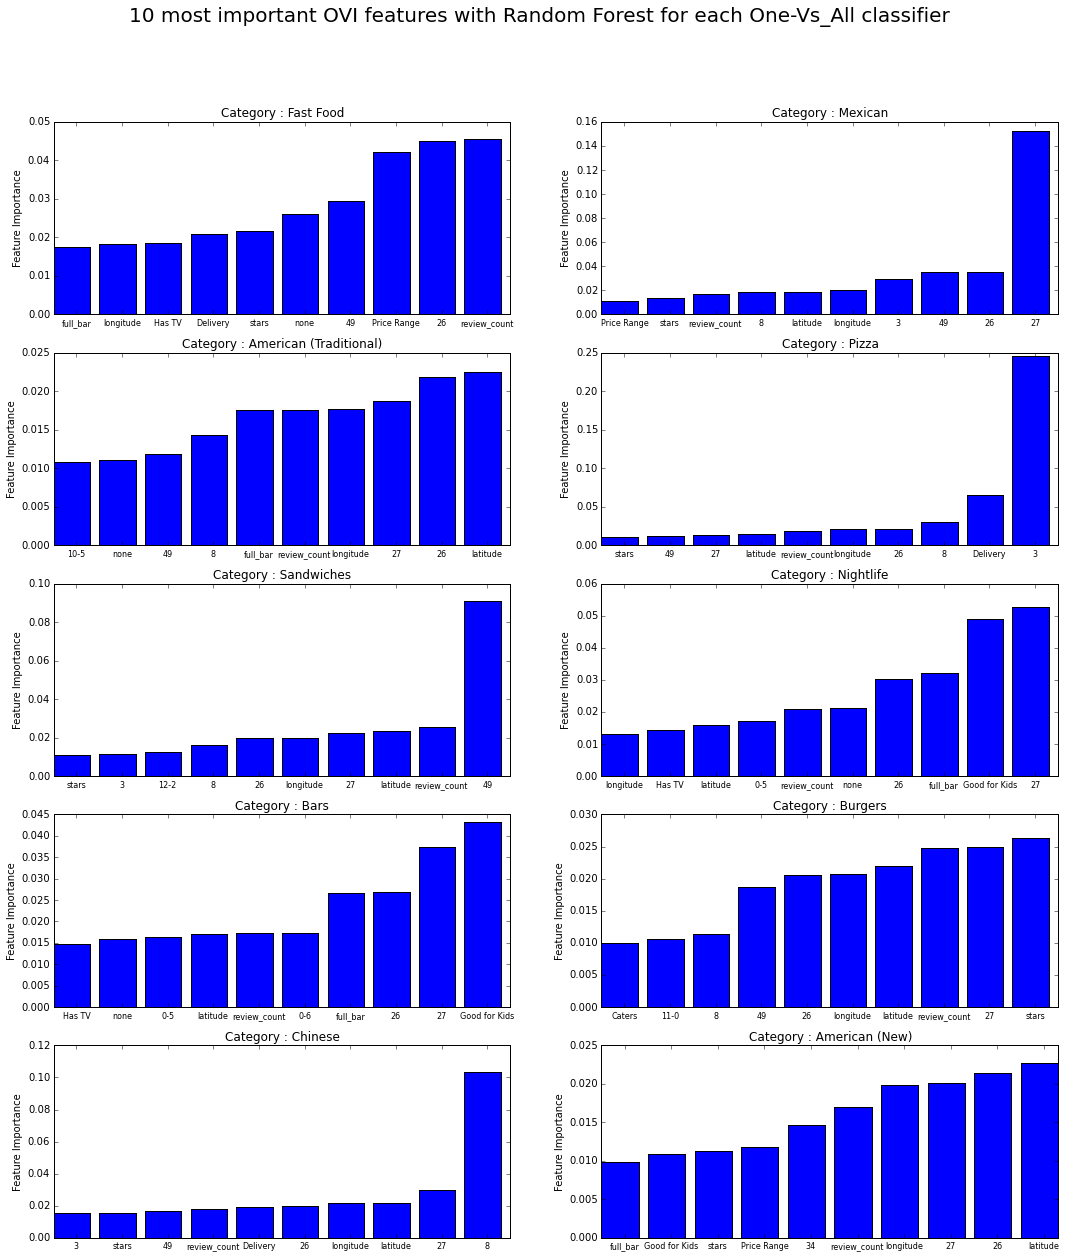

In [131]:
# ### OVI features

# Global data for the plot
cols = ovi_df_train.columns
ind = np.arange(10)
width = 1
top_feat = 10

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20))

for ax, category in zip(axes.ravel(), top_10):
    # Fetching data for the plot
    feat_imp = rf_dict_ovi[category].feature_importances_
    labels = cols.values[np.argsort(feat_imp)[-top_feat:]]
    data_pl = np.sort(feat_imp)[-top_feat:]
    
    #fig.set_size_inches(9, 4)
    ax.bar(ind, data_pl)

    ax.set_title('Category : {}'.format(category))
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(tuple(labels.astype(str)), fontsize=8)
    ax.set_ylabel('Feature Importance')

plt.suptitle('10 most important OVI features with Random Forest for each One-Vs_All classifier', fontsize=20)
plt.plot()

[]

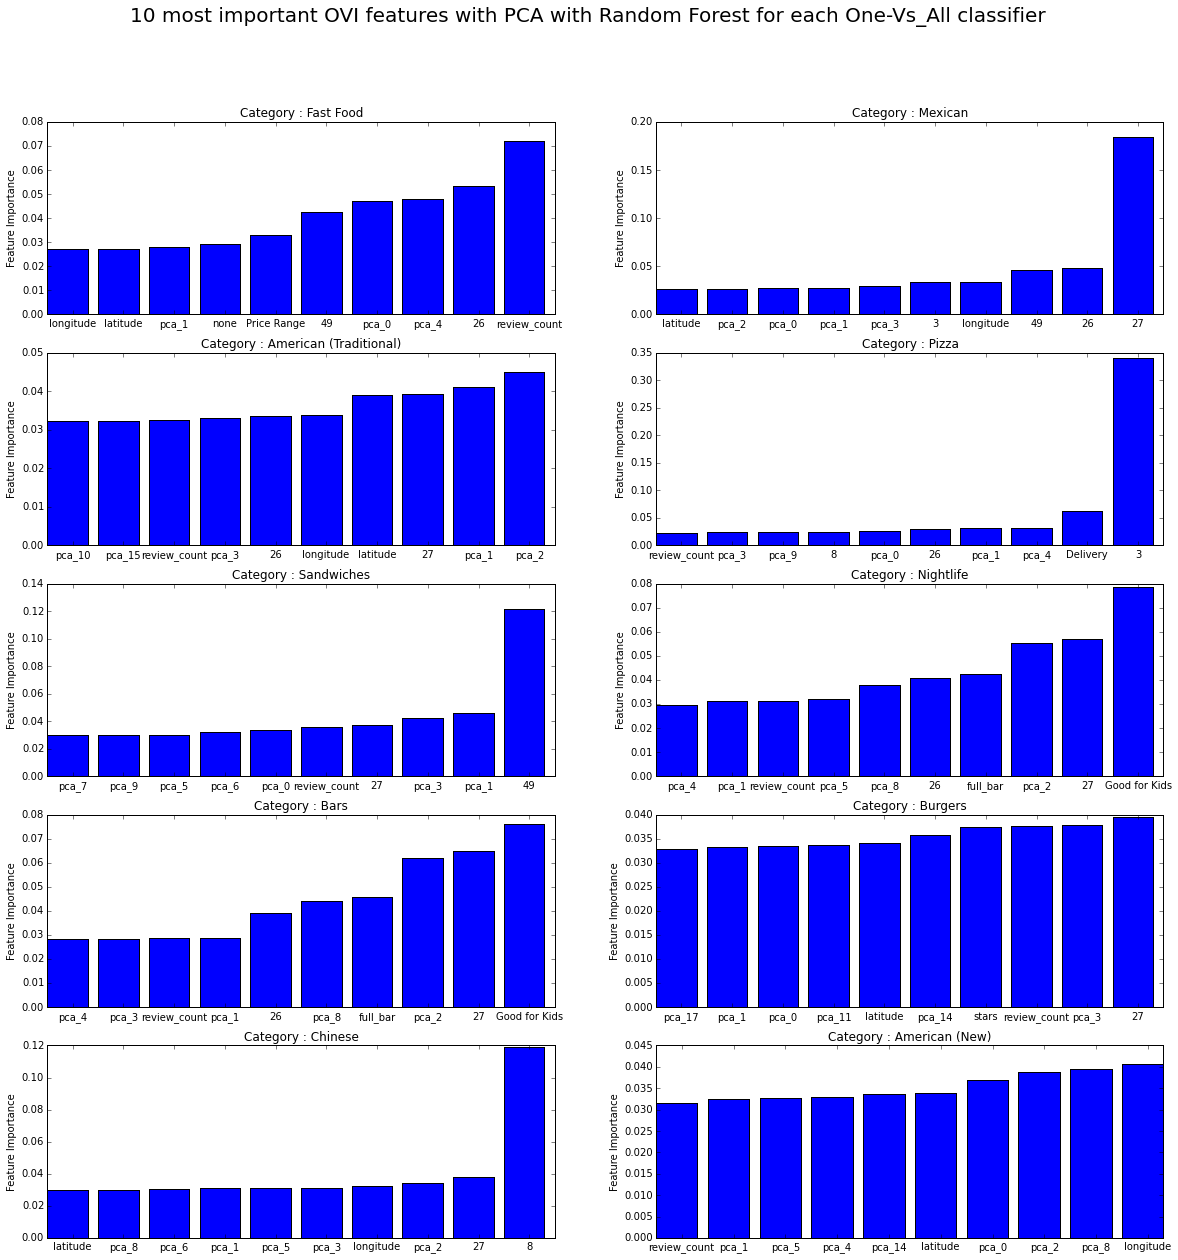

In [133]:
# ### OVI features with PCA

# Global data for the plot
cols = np.array(ovi_df_pca_columns)
ind = np.arange(10)
width = 1
top_feat = 10

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

for ax, category in zip(axes.ravel(), top_10):
    # Fetching data for the plot
    feat_imp = rf_dict_ovi_pca[category].feature_importances_
    labels = cols[np.argsort(feat_imp)[-top_feat:]]
    data_pl = np.sort(feat_imp)[-top_feat:]
    
    #fig.set_size_inches(9, 4)
    ax.bar(ind, data_pl)

    ax.set_title('Category : {}'.format(category))
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(tuple(labels.astype(str)))
    ax.set_ylabel('Feature Importance')

plt.suptitle('10 most important OVI features with PCA with Random Forest for each One-Vs_All classifier', fontsize=20)
plt.plot()

In [96]:
# ### GS features
topics_words_dict = get_topic(topics_gs, lv_vocab10, 10)
for k,v in topics_words_dict.iteritems():
    print(u'Topic {}: {}'.format(k, ' '.join(v)))

Topic 0: beef sauce sashimi fish miso sake yellowtail rice chef item
Topic 1: drink music night club bar fun girl party band floor
Topic 2: dinner waiter appetizer dessert meal wine entree night sauce cocktail
Topic 3: pancake waffle breakfast bacon egg biscuit potato velvet hash wait
Topic 4: dog fry chili cheese beef onion hotdog bun topping sausage
Topic 5: location minute employee guy area day kid drink drive home
Topic 6: coffee tea drink boba milk shop latte cup cafe ice
Topic 7: view fountain strip window patio reservation water seat floor waterfall
Topic 8: taco meat burrito pork salsa sauce fry tortilla cheese flavor
Topic 9: shrimp crab sauce fry crawfish seafood juicy flavor catfish potato
Topic 10: cheese mac pudding truffle bone bread marrow tot drink beef
Topic 11: meat rib pork brisket sauce cheese potato bean bbq flavor
Topic 12: room hotel pool casino strip floor bed night day elevator
Topic 13: corn sauce bread pork tamale flavor cheese shrimp meal chicken
Topic 14: l

[]

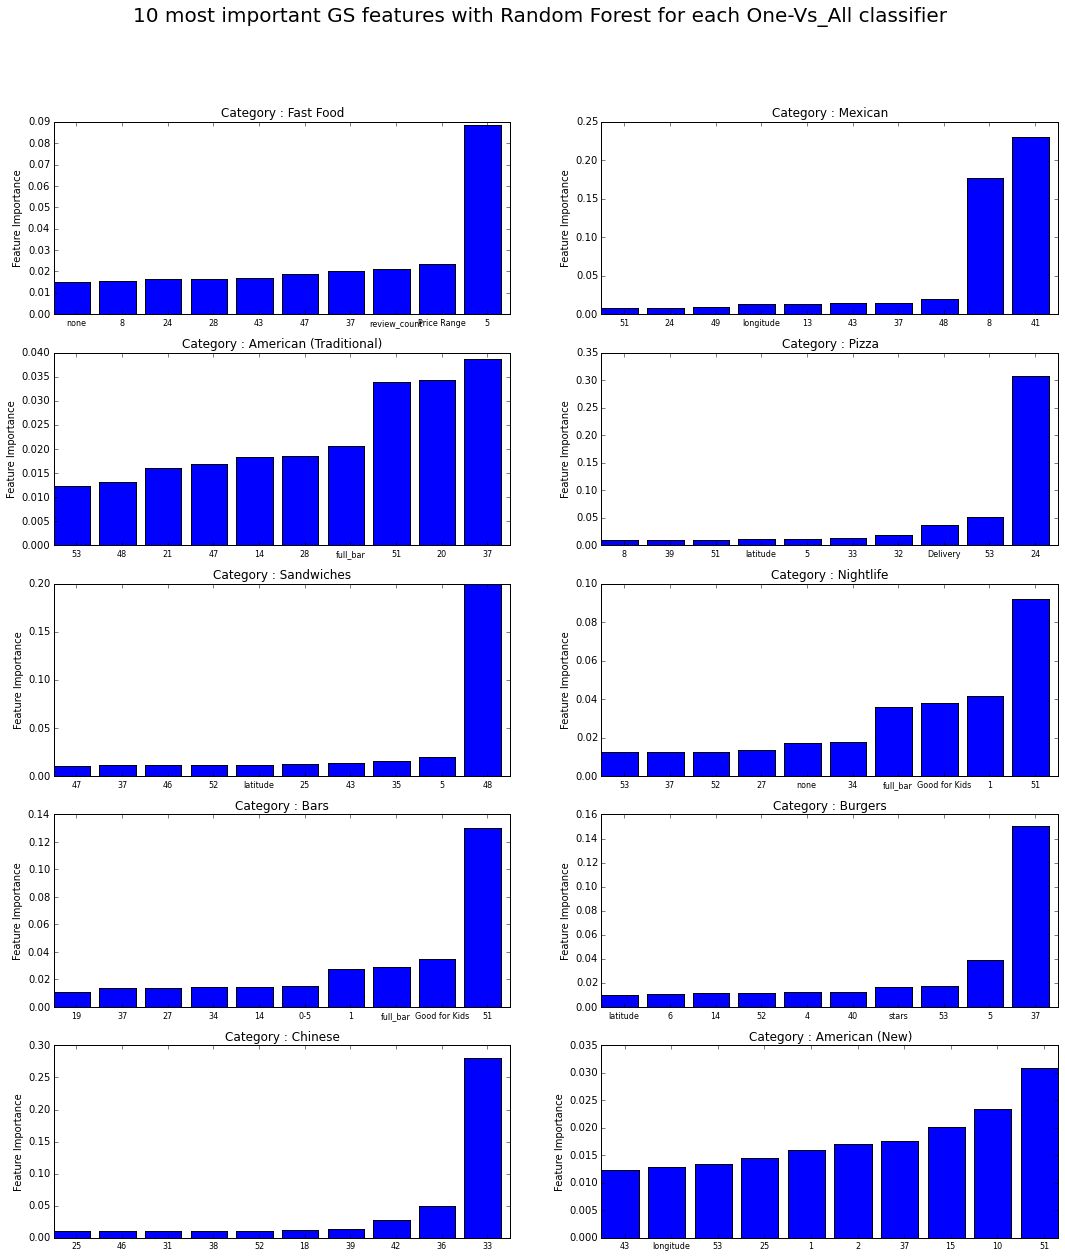

In [135]:
# ### GS features

# Global data for the plot
cols = gs_df[mask].drop(categories, axis=1).columns
ind = np.arange(10)
width = 1
top_feat = 10

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 20))

for ax, category in zip(axes.ravel(), top_10):
    # Fetching data for the plot
    feat_imp = rf_dict_gs[category].feature_importances_
    labels = cols.values[np.argsort(feat_imp)[-top_feat:]]
    data_pl = np.sort(feat_imp)[-top_feat:]
    
    #fig.set_size_inches(9, 4)
    ax.bar(ind, data_pl)

    ax.set_title('Category : {}'.format(category))
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(tuple(labels.astype(str)), fontsize=8)
    ax.set_ylabel('Feature Importance')

plt.suptitle('10 most important GS features with Random Forest for each One-Vs_All classifier', fontsize=20)
plt.plot()

[]

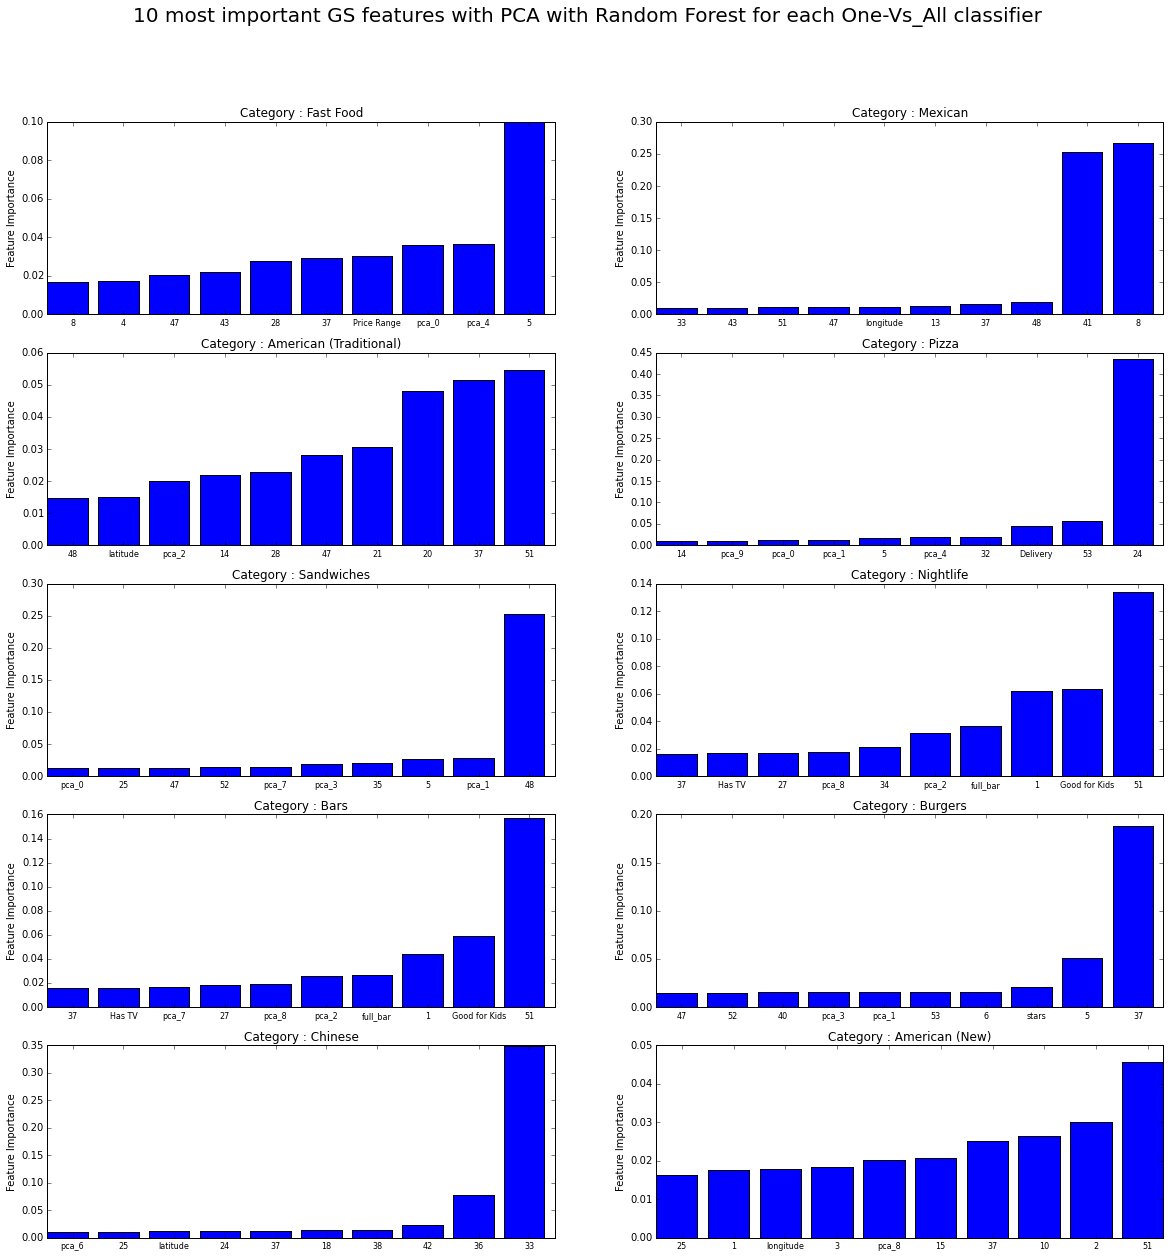

In [136]:
# ### GS features with PCA

# Global data for the plot
cols = np.array(gs_df_pca_columns)
ind = np.arange(10)
width = 1
top_feat = 10

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

for ax, category in zip(axes.ravel(), top_10):
    # Fetching data for the plot
    feat_imp = rf_dict_gs_pca[category].feature_importances_
    labels = cols[np.argsort(feat_imp)[-top_feat:]]
    data_pl = np.sort(feat_imp)[-top_feat:]
    
    #fig.set_size_inches(9, 4)
    ax.bar(ind, data_pl)

    ax.set_title('Category : {}'.format(category))
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(tuple(labels.astype(str)), fontsize=8)
    ax.set_ylabel('Feature Importance')

plt.suptitle('10 most important GS features with PCA with Random Forest for each One-Vs_All classifier', fontsize=20)
plt.plot()

In [103]:
len(ovi_df_pca_columns)
ovi_df_pca.shape

(3743, 187)

### ROC Curve

In [159]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

fpr_lasso = dict()
tpr_lasso = dict()
roc_auc_lasso = dict()

fpr_rfc = dict()
tpr_rfc = dict()
roc_auc_rfc = dict()

for category in top_10:
    # LAsso GS PCA
    lasso_gs_pca = LogisticRegression(penalty='l1')
    lasso_gs_pca.fit(gs_df_pca_train, Y_gs_train[category])
    # RFC GS PCA
    rfc_gs = RandomForestClassifier(max_depth=20, n_estimators=50)
    rfc_gs.fit(gs_df_pca_train, Y_gs_train[category])

    # OVI
    fpr_lasso[category], tpr_lasso[category], _ = roc_curve(Y_gs_test[category], lasso_gs_pca.decision_function(gs_df_pca_test))
    roc_auc_lasso[category] = auc(fpr_lasso[category], tpr_lasso[category])

    # NMF
    fpr_rfc[category], tpr_rfc[category], _ = roc_curve(Y_gs_test[category], rfc_gs.predict_proba(gs_df_pca_test)[:, 1])
    roc_auc_rfc[category] = auc(fpr_rfc[category], tpr_rfc[category])

Automatically created module for IPython interactive environment


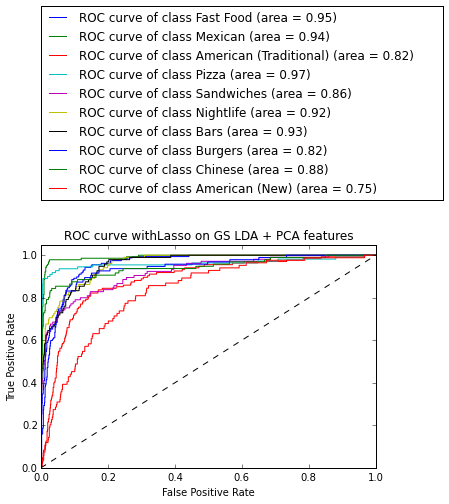

In [160]:
# Plot Lasso
plt.figure()

for category in top_10:
    plt.plot(fpr_lasso[category], tpr_lasso[category], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(category, roc_auc_ovi[category]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve withLasso on GS LDA + PCA features')
plt.legend(bbox_to_anchor=(0., 1.2, 1.2, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

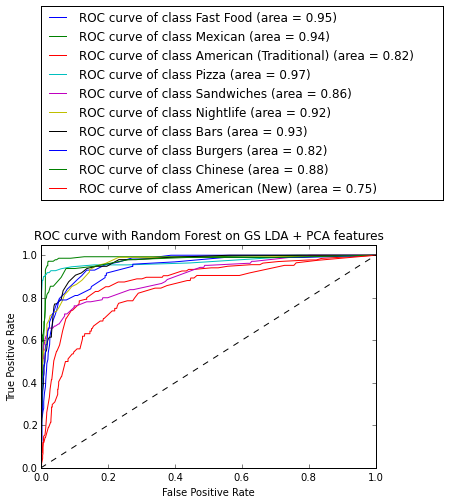

In [161]:
# Plot all OVI ROC curves
plt.figure()

for category in top_10:
    plt.plot(fpr_rfc[category], tpr_rfc[category], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(category, roc_auc_ovi[category]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve with Random Forest on GS LDA + PCA features')
plt.legend(bbox_to_anchor=(0., 1.2, 1.2, .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

In [162]:
categories_serie

Fast Food                    553
Mexican                      476
American (Traditional)       403
Pizza                        365
Sandwiches                   354
Nightlife                    345
Bars                         322
Burgers                      296
Chinese                      286
American (New)               280
Food                         257
Italian                      232
Japanese                     201
Breakfast & Brunch           156
Steakhouses                  149
Sushi Bars                   142
Seafood                      132
Thai                         103
Cafes                         97
Sports Bars                   96
Barbeque                      93
Asian Fusion                  91
Buffets                       88
Chicken Wings                 85
Delis                         85
Mediterranean                 68
Korean                        65
Pubs                          62
Hot Dogs                      57
Hawaiian                      57
          

In [4]:
type('st') is str

True